In [59]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_auc_score, roc_curve, hamming_loss,precision_score,recall_score,f1_score

from confusion import make_confusion_matrix
import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import warnings
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [60]:
data = pd.read_csv(f'../app/data/processed_data.csv')


In [61]:
data.head()

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city,target
0,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states,3.0
1,s&p global,panjiva is a data-driven technology company th...,united states,3.9,NaN,working with our data scientists to turn large...,data engineer - data science platforms & infra...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data-driven technology company th...,141000.0,2022-05-31,united states,united states,3.0
2,cybercoders,data scientist if you are a data scient...,"remote in phoenix, az 85021",3.6,NaN,collaborate with analytics teams to create ins...,data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,data scientist if you are a data scient...,105000.0,2022-05-31,az,remote in phoenix,2.0
3,standard chartered,job: data and analytics primary location: as...,"san francisco, ca 94105 (financial district/so...",4.1,NaN,develop machine learning and advanced analytic...,specialist data scientist,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,job: data and analytics primary location: as...,119000.0,2022-05-31,ca,san francisco,2.0
4,youappi,ml engineer that will be responsible for train...,"los angeles, ca",3.3,NaN,"worked on big data projects in the past, and p...",ml engineer,https://www.indeed.com/rc/clk?jk=350fdd180edea...,ml engineer that will be responsible for train...,84000.0,2022-05-31,ca,los angeles,1.0


In [62]:
data.text[0]

'panjiva is a data-driven technology company that uses machine learning to provide powerful search, analysis, and visualization of billions of shipping records from nearly every country in the world. more than 3,000 customers in over 100 countries, ranging from fortune 500 companies and startups to government agencies and hedge funds, rely on our platform for supply chain intelligence. in global trade, better insight means better decision making and stronger connections between companies and governments across the globe.recognizing panjiva’s cutting-edge technology, s&p global acquired panjiva in 2018. this acquisition has grown our resources, dramatically expanded our access to data, and accelerated our growth plans.people are panjiva’s greatest strength – join our engineering team as we map out a key part of the world economy!job descriptionas a data engineer on our team, you will play a key role in developing our next-generation data science infrastructure and underlying core techno

In [63]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


In [64]:
def clean_text(data):
    sentences = data.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|(0-9)]',r'',clean_sentence.strip(' '))
        if len(clean_sentence.strip()) > 1:
            clean_sentences.append(clean_sentence)
    done_sent = ''
    for i in clean_sentences:
        done_sent += (' '+i)
    return done_sent.strip()
    

data['cleaned'] = data.text.apply(clean_text)

In [65]:
data.cleaned[0]

'panjiva is a data-driven technology company that uses machine learning to provide powerful search analysis and visualization of billions of shipping records from nearly every country in the world more than  customers in over  countries ranging from fortune  companies and startups to government agencies and hedge funds rely on our platform for supply chain intelligence in global trade better insight means better decision making and stronger connections between companies and governments across the globe recognizing panjiva’s cutting-edge technology s&p global acquired panjiva in  this acquisition has grown our resources dramatically expanded our access to data and accelerated our growth plans people are panjiva’s greatest strength – join our engineering team as we map out a key part of the world economyjob descriptionas a data engineer on our team you will play a key role in developing our next-generation data science infrastructure and underlying core technologies you will work with pa

In [66]:
def clean_text(data):
    sentences = data.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r'',clean_sentence)
        clean_sentence = " ".join(re.findall("[(a-zA-Z,&)]+", clean_sentence))
        clean_sentences.append(clean_sentence)
    clean_text = ''
    for i in clean_sentences:
        clean_text += (' '+i)
    return clean_text.strip(' ')

    

data['cleaned'] = data.text.apply(clean_text)



In [67]:
data.cleaned[3]

'job data and analytics primary location asia singapore singapore other locations europe & americas united states san francisco europe & americas united kingdom london schedule full time employee status permanent posting date may am unposting date jun pm about standard chartered were an international bank nimble enough to act big enough for impact for more than years weve worked to make a positive difference for our clients communities and each other we question the status quo love a challenge and enjoy finding new opportunities to grow and do better than before if youre looking for a career with purpose and you want to work for a bank making a difference we want to hear from you you can count on us to celebrate your unique talents and we cant wait to see the talents you can bring us our purpose to drive commerce and prosperity through our unique diversity together with our brand promise to be here for good are achieved by how we each live our valued behaviours when you work with us yo

### 4.1 Target
Before I can begin splitting the data I need to set the target for my methodology of training four seperate logistic regression models. I'm doing this because I'd like my classifications to be as accurate as possible, and also, by building my NLP strategy around a particular label, i.e. finding common words for that label as opposed to being generalized through the entire corpus\

I'm going to one-hot-encode the target feature so I can select each of the next columns as my y - one for each model.

In [68]:
data = data[['company','job_title','state','city','rating','cleaned','target','salary', 'dateposted','summary','url']]

In [69]:
ohe = OneHotEncoder(sparse=False, dtype='int')
targets = ohe.fit_transform(pd.DataFrame(data.target))


In [70]:
targets = pd.DataFrame(targets,columns=['Q1','Q2','Q3','Q4','unk'])


In [71]:
data = data.join(targets)
data.head()

,company,job_title,state,city,rating,cleaned,target,salary,dateposted,summary,url,Q1,Q2,Q3,Q4,unk
0,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,panjiva is a data driven technology company th...,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,0,1,0,0
1,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,panjiva is a data driven technology company th...,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,0,1,0,0
2,cybercoders,data scientist,az,remote in phoenix,3.6,data scientist if you are a data scientist wit...,2.0,105000.0,2022-05-31,collaborate with analytics teams to create ins...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,1,0,0,0
3,standard chartered,specialist data scientist,ca,san francisco,4.1,job data and analytics primary location asia s...,2.0,119000.0,2022-05-31,develop machine learning and advanced analytic...,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,0,1,0,0,0
4,youappi,ml engineer,ca,los angeles,3.3,ml engineer that will be responsible for train...,1.0,84000.0,2022-05-31,"worked on big data projects in the past, and p...",https://www.indeed.com/rc/clk?jk=350fdd180edea...,1,0,0,0,0


In [72]:
data.drop(['unk'], axis=1,inplace=True)

In [73]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


data['comment_text'] = data['cleaned'].apply(stemming)

In [74]:
data.comment_text[0]

'panjiva is a data driven technolog compani that use machin learn to provid power search analysi and visual of billion of ship record from near everi countri in the world more than custom in over countri rang from fortun compani and startup to govern agenc and hedg fund reli on our platform for suppli chain intellig in global trade better insight mean better decis make and stronger connect between compani and govern across the globe recogn panjiva s cut edg technolog s&p global acquir panjiva in this acquisit has grown our resourc dramat expand our access to data and acceler our growth plan peopl are panjiva s greatest strength join our engin team as we map out a key part of the world economyjob descriptiona a data engin on our team you will play a key role in develop our next generat data scienc infrastructur and under core technolog you will work with panjiva s world class data scientist analyst and engin to creat product that solv import real world busi problem in a collabor fast pa

In [75]:
from nltk.stem import WordNetLemmatizer



lemmatizer = WordNetLemmatizer()
def stemming(sentence):
    LemSentence = ""
    for word in sentence.split():
        stem = lemmatizer.lemmatize(word)
        LemSentence += stem
        LemSentence += " "
    LemSentence = LemSentence.strip()
    return LemSentence


data['comment_text_lem'] = data['cleaned'].apply(stemming)
data.comment_text_lem[0]

'panjiva is a data driven technology company that us machine learning to provide powerful search analysis and visualization of billion of shipping record from nearly every country in the world more than customer in over country ranging from fortune company and startup to government agency and hedge fund rely on our platform for supply chain intelligence in global trade better insight mean better decision making and stronger connection between company and government across the globe recognizing panjiva s cutting edge technology s&p global acquired panjiva in this acquisition ha grown our resource dramatically expanded our access to data and accelerated our growth plan people are panjiva s greatest strength join our engineering team a we map out a key part of the world economyjob descriptionas a data engineer on our team you will play a key role in developing our next generation data science infrastructure and underlying core technology you will work with panjiva s world class data scien

In [76]:
data.drop(['cleaned','comment_text'], axis=1,inplace=True)

In [77]:
data

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,Q1,Q2,Q3,Q4,comment_text_lem
0,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,0,1,0,panjiva is a data driven technology company th...
1,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,0,1,0,panjiva is a data driven technology company th...
2,cybercoders,data scientist,az,remote in phoenix,3.6,2.0,105000.0,2022-05-31,collaborate with analytics teams to create ins...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,0,1,0,0,data scientist if you are a data scientist wit...
3,standard chartered,specialist data scientist,ca,san francisco,4.1,2.0,119000.0,2022-05-31,develop machine learning and advanced analytic...,https://www.indeed.com/rc/clk?jk=0c043ee62c575...,0,1,0,0,job data and analytics primary location asia s...
4,youappi,ml engineer,ca,los angeles,3.3,1.0,84000.0,2022-05-31,"worked on big data projects in the past, and p...",https://www.indeed.com/rc/clk?jk=350fdd180edea...,1,0,0,0,ml engineer that will be responsible for train...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,etsy,senior applied scientist ii-knowledge base,wa,remote in seattle,4.3,NaN,NaN,2022-04-19,you have familiarity with machine learning and...,https://www.indeed.com/rc/clk?jk=ce2571b93c5e9...,0,0,0,0,company description etsy is the global marketp...
1236,nike,"senior data scientist (open to remote work, ex...",or,remote in beaverton,4.1,NaN,NaN,2022-04-20,data scientist in the gsm advanced analytics s...,https://www.indeed.com/rc/clk?jk=31de37c3c5f99...,0,0,0,0,become a part of the nike inc teamnike inc doe...
1237,windstream communications,senior data scientist,remote,remote,3.2,NaN,NaN,2022-04-20,you will also be responsible for acquisition o...,https://www.indeed.com/rc/clk?jk=5362358221574...,0,0,0,0,we are looking for a data scientist to help u ...
1238,nike,"senior data scientist (open to remote work, ex...",or,remote in beaverton,4.1,NaN,NaN,2022-04-20,data scientist in the gsm advanced analytics s...,https://www.indeed.com/rc/clk?jk=31de37c3c5f99...,0,0,0,0,become a part of the nike inc teamnike inc doe...


I need to make one model for each target. Before doing so, I'll need to use gridsearch to find the best hyperperamters.
Looping through each target, I set y to that specific single-column binary '(for target in targets target == 0 or 1)'
Then do a test train split before setting up the pipeline. The grid being use in this case is the selection of hyperperamters I want to check.


In [78]:
def grid_search_pipe():
    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    le_cols = ['company', 'job_title', 'state', 'city']
    scal_cols = ['rating']

    evaluations = {}

    
    for i in targets:
    # test/train split
        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)


        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'comment_text_lem'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', StandardScaler(), scal_cols)
                
                ],remainder='drop')
        #   populating parameter grid to search
        grid = [
            {
            'classifier' : [LogisticRegression()],
            #'classifier__penalty' : ['l1', 'l2'],
            #'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__solver' : ['liblinear']}
            ]

        pipe = Pipeline(
            steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(grid)),
            ],
            )


        
        grid_search = GridSearchCV(pipe, param_grid=grid, verbose=2, return_train_score=True)
        grid_search.fit(x_train,y_train)

        print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
        print(grid_search.best_params_)


        if i not in evaluations.keys():
            evaluations[i] = {
                'grid_search':grid_search,
                'x_train':x_train,
                'y_train':y_train,
                'x_test':x_test,
                'y_test':y_test
                
            }


    return evaluations


evaluations = grid_search_pipe()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.1s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.0s
Best parameter (CV score=0.972):
{'classifier': LogisticRegression(solver='liblinear'), 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.1s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   1.0s
[CV] END classifier=LogisticReg

In [79]:
def make_model(evaluations):


    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    test_results = {}

    for i in targets:
        evaluation = evaluations[i]['grid_search']
        params = evaluation.best_params_


        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)



        le_cols = ['company', 'job_title', 'state', 'city']
        scal_cols = ['rating']

        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'comment_text_lem'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', MinMaxScaler(), scal_cols)
                
                ],remainder='drop')


        pipe = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', params['classifier']),
            ],
        )


        pipe.fit(x_train,y_train)

        predictions = pipe.predict(x_test)
        score = pipe.score(x_train, y_train)


        ### check
        check = pd.DataFrame(preprocessor.fit_transform(x_train,y_train).toarray())


        if i not in test_results.keys():
            test_results[i] = pipe, x_train, y_train, x_test, y_test, predictions, score
                
    return test_results, check
        
test_results, check = make_model(evaluations)


In [80]:
def combinator(test_results):
    targets = ['Q1','Q2','Q3','Q4']

    resultsDB = {}
    lst = []

    
    for label in targets:
        data_dict = {}
        pipe = test_results[label][0]
        x_test = test_results[label][3]
        y_test = test_results[label][4]
        y_prob = pipe.predict_proba(x_test)
        predict_y = pipe.predict(x_test)
        data_dict = {
            f'{label}_y_test':y_test, 
             f'{label}_pred y': predict_y.tolist(),
             f'{label}_probabilities': y_prob.tolist()
             }
        zulu = x_test.join(pd.DataFrame(data_dict))
        if label not in resultsDB.keys():
            resultsDB[label] = zulu
        else:
            continue


        out = pd.DataFrame(data_dict)
        lst.append(out)

    results_table = x_test
    for i, label in zip(lst, targets):
        results_table = results_table.join(i, lsuffix=label)
    #results_table = results_table.join(lst[1], lsuffix='__')
    #for label, results in zip(targets,lst):
    #    results_table = results_table.join(results, lsuffix=label)
    return resultsDB, results_table, lst
   

data_dict, results_table, lst = combinator(test_results)

In [81]:
len(test_results['Q1'])

7

In [82]:
pipe = test_results['Q1'][0]
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(decode_error='ignore',
                                                                  max_features=1000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'comment_text_lem'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['company', 'job_title',
                                                   'state', 'city']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['rating'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [83]:
x_train = test_results['Q1'][1]
x_train

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,comment_text_lem
918,ford motor company,geospatial data scientist - remote,mi,remote in dearborn,4.1,NaN,NaN,2022-04-13,experience with methods and tasks to strengthe...,https://www.indeed.com/rc/clk?jk=3eddce4bcdcd9...,dearbornford motor companyautonomous vehiclesj...
693,holland america line,"data scientist, marketing analytics and campai...",fl,remote in miami,4.0,1.0,84000.0,2022-04-19,experience on machine learning and data modell...,https://www.indeed.com/rc/clk?jk=5e3f1dafd72a9...,job description welcome to holland america lin...
528,galaxe.solutions,data analyst,wi,remote in milwaukee,2.5,1.0,76000.0,2022-04-16,what you will do: well acquainted with the dba...,https://www.indeed.com/rc/clk?jk=a655138ed85d8...,what you will dowell acquainted with the dba r...
409,revel,senior data scientist - routing algorithm,ny,remote in brooklyn,2.6,3.0,134000.0,2022-04-17,"lead the development of our ride assignment, r...",https://www.indeed.com/company/Revel/jobs/Seni...,about revelrevels mission is to accelerate ev ...
533,s&p global,data scientist,tn,remote in nashville,3.9,2.0,112000.0,2022-04-16,"strong statistical knowledge and intuition, es...",https://www.indeed.com/rc/clk?jk=542c2bd04ed91...,segment market intelligence the role data scie...
...,...,...,...,...,...,...,...,...,...,...,...
1044,target,senior data scientist,mn,remote in minneapolis,3.6,NaN,NaN,2022-04-16,must also have 24 months of experience (which ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,location nicollet mall minneapolis minnesota u...
1095,target,senior data scientist,mn,remote in minneapolis,3.6,NaN,NaN,2022-04-16,"location: 1000 nicollet mall, minneapolis, min...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,location nicollet mall minneapolis minnesota u...
1130,spartannash,data scientist,mi,remote in algonac,3.4,NaN,NaN,2022-04-19,as a data scientist you would apply innovative...,https://www.indeed.com/rc/clk?jk=eb40022b3a7e9...,at spartannash we deliver the ingredient for a...
860,endevis,software engineer - machine learning,mi,northville,3.3,NaN,NaN,2022-05-31,apply relevant scientific rigor to analyze tes...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,software engineer machine learningabout u we s...


In [84]:
y_train = test_results['Q1'][2]
y_train

918     0
693     1
528     1
409     0
533     0
       ..
1044    0
1095    0
1130    0
860     0
1126    0
Name: Q1, Length: 992, dtype: int64

In [85]:
x_test = test_results['Q1'][3]
x_test

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,comment_text_lem
415,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-17,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=4c2d6184ae3a9...,we are currently seeking a senior data scienti...
259,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,business analytics analyst industry bankingfin...
332,revel,senior data scientist - routing algorithm,ny,remote in brooklyn,2.6,3.0,134000.0,2022-04-17,"lead the development of our ride assignment, r...",https://www.indeed.com/company/Revel/jobs/Seni...,about revelrevels mission is to accelerate ev ...
622,spotify,"data scientist, advertising economics",ny,remote in new york,4.3,2.0,124000.0,2022-04-19,you have the technical competence to perform m...,https://www.indeed.com/rc/clk?jk=2a61db000f6f7...,data research & insightsdata scienceat spotify...
101,techtrueup,mcs data scientist,remote,remote,3.8,3.0,136000.0,2022-04-13,work closely with subject matter experts to de...,https://www.indeed.com/company/TechTrueUP/jobs...,description data scientist fully remote develo...
...,...,...,...,...,...,...,...,...,...,...,...
649,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-19,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=7202813e18dba...,we are currently seeking a senior data scienti...
976,optum,senior data scientist - telecommute,mn,remote in eden prairie,3.4,NaN,NaN,2022-04-15,"develop advanced analytics, algorithms and pre...",https://www.indeed.com/rc/clk?jk=32278338362a8...,combine two of the fastest growing field on th...
178,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,business analytics analyst industry bankingfin...
31,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,panjiva is a data driven technology company th...


In [86]:
y_test = test_results['Q1'][4]
y_test

415    0
259    1
332    0
622    0
101    0
      ..
649    0
976    0
178    1
31     0
519    1
Name: Q1, Length: 248, dtype: int64

In [87]:
predictions =  test_results['Q1'][5]
predictions

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1])

In [88]:
score =  test_results['Q1'][6]
score

0.9838709677419355

In [89]:
score = pipe.score(x_train, y_train)
score

0.9838709677419355

In [90]:

predictions = pipe.predict(x_test)
predictions

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1])

In [91]:
print("Accuracy :",accuracy_score(y_test, predictions))

Accuracy : 0.9637096774193549


In [92]:

print("Hamming loss ",hamming_loss(y_test,predictions))

Hamming loss  0.036290322580645164


In [93]:

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

In [94]:
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Micro-average quality numbers
Precision: 0.9637, Recall: 0.9637, F1-measure: 0.9637


In [95]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

In [96]:
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Macro-average quality numbers
Precision: 0.9106, Recall: 0.9680, F1-measure: 0.9361


In [97]:
print("\nClassification Report")
print (classification_report(y_test, predictions))


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       209
           1       0.83      0.97      0.89        39

    accuracy                           0.96       248
   macro avg       0.91      0.97      0.94       248
weighted avg       0.97      0.96      0.96       248



In [98]:

pipe.score(x_train, y_train)

0.9838709677419355

In [99]:
cf1 = confusion_matrix(y_test, predictions)

In [100]:
Q = ['Q1']
te_confusions = [cf1]
y_t = [y_test]
te_probs = [pipe.predict_proba(x_test)]
y_pred = [predictions]
y_test_preds = predictions
y_prob = [pipe.predict_proba(x_test)]

In [101]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       209
           1       0.83      0.97      0.89        39

    accuracy                           0.96       248
   macro avg       0.91      0.97      0.94       248
weighted avg       0.97      0.96      0.96       248



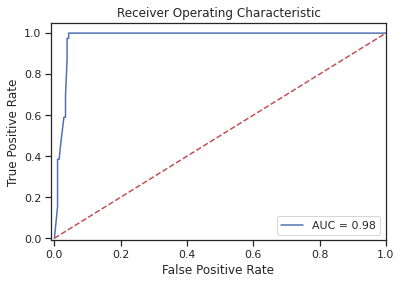

In [102]:
import sklearn.metrics as metrics# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-.01, 1.])
plt.ylim([-.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

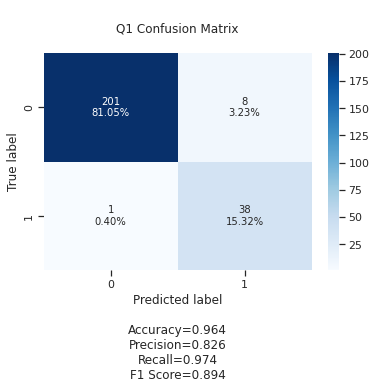

In [103]:
for title, cf, y_t, y_pred, y_prob in zip(Q, te_confusions, y_test, y_test_preds, te_probs):
    make_confusion_matrix(cf, title='\n'+title+' Confusion Matrix\n')


In [104]:
results_table

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q1_probabilities,Q2_y_test,Q2_pred y,Q2_probabilities,Q3_y_test,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities
415,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-17,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=4c2d6184ae3a9...,...,"[0.9900624415675039, 0.009937558432496052]",0,0,"[0.9872024692275917, 0.012797530772408269]",0,0,"[0.9939853440372725, 0.0060146559627275616]",1,1,"[0.030479877886147033, 0.969520122113853]"
259,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,"[0.11995925730469581, 0.8800407426953042]",0,0,"[0.9563342878151998, 0.043665712184800205]",0,0,"[0.9847584551660893, 0.01524154483391073]",0,0,"[0.9786976543301501, 0.02130234566984989]"
332,revel,senior data scientist - routing algorithm,ny,remote in brooklyn,2.6,3.0,134000.0,2022-04-17,"lead the development of our ride assignment, r...",https://www.indeed.com/company/Revel/jobs/Seni...,...,"[0.9888317482652479, 0.01116825173475211]",0,0,"[0.9839762819161306, 0.01602371808386938]",1,1,"[0.1198178401852108, 0.8801821598147892]",0,0,"[0.9919646521560592, 0.00803534784394078]"
622,spotify,"data scientist, advertising economics",ny,remote in new york,4.3,2.0,124000.0,2022-04-19,you have the technical competence to perform m...,https://www.indeed.com/rc/clk?jk=2a61db000f6f7...,...,"[0.9927110640618497, 0.00728893593815029]",1,1,"[0.283728870384262, 0.716271129615738]",0,0,"[0.983835610976363, 0.016164389023637076]",0,0,"[0.991701251517981, 0.00829874848201899]"
101,techtrueup,mcs data scientist,remote,remote,3.8,3.0,136000.0,2022-04-13,work closely with subject matter experts to de...,https://www.indeed.com/company/TechTrueUP/jobs...,...,"[0.959413938059762, 0.04058606194023799]",0,0,"[0.9849644852004064, 0.015035514799593617]",1,1,"[0.10772038055991329, 0.8922796194400867]",0,0,"[0.9751230277308611, 0.024876972269138847]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-19,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=7202813e18dba...,...,"[0.9900624415675039, 0.009937558432496052]",0,0,"[0.9872024692275917, 0.012797530772408269]",0,0,"[0.9939853440372725, 0.0060146559627275616]",1,1,"[0.030479877886147033, 0.969520122113853]"
976,optum,senior data scientist - telecommute,mn,remote in eden prairie,3.4,NaN,NaN,2022-04-15,"develop advanced analytics, algorithms and pre...",https://www.indeed.com/rc/clk?jk=32278338362a8...,...,"[0.9881425746373823, 0.01185742536261766]",0,0,"[0.9863672102017922, 0.013632789798207775]",0,0,"[0.9904920928397499, 0.00950790716025006]",0,0,"[0.989367174888377, 0.010632825111622946]"
178,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,"[0.11995925730469581, 0.8800407426953042]",0,0,"[0.9563342878151998, 0.043665712184800205]",0,0,"[0.9847584551660893, 0.01524154483391073]",0,0,"[0.9786976543301501, 0.02130234566984989]"
31,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,"[0.9920316038061282, 0.00796839619387179]",0,0,"[0.9830947581472335, 0.01690524185276649]",1,1,"[0.04120769108837785, 0.9587923089116221]",0,0,"[0.9913364166892068, 0.008663583310793206]"


In [105]:
def Q(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """
    #np.argmax(row[['Q1_Prob', 'Q2_Prob','Q3_Prob','Q4_Prob']].values)
    Q1 = row['Q1_probabilities'][1]
    Q2 = row['Q2_probabilities'][1]
    Q3 = row['Q3_probabilities'][1]
    Q4 = row['Q4_probabilities'][1]
    lst = [Q1,Q2,Q3,Q4]
    # adding 1 so these correspond to the target names rather than 0 indexed.
    return int(lst.index(max(lst))+1)
    #next, check if that 


results_table['Q'] = results_table.apply( lambda row : Q(row), axis = 1)
results_table


,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q2_y_test,Q2_pred y,Q2_probabilities,Q3_y_test,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities,Q
415,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-17,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=4c2d6184ae3a9...,...,0,0,"[0.9872024692275917, 0.012797530772408269]",0,0,"[0.9939853440372725, 0.0060146559627275616]",1,1,"[0.030479877886147033, 0.969520122113853]",4
259,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,0,"[0.9563342878151998, 0.043665712184800205]",0,0,"[0.9847584551660893, 0.01524154483391073]",0,0,"[0.9786976543301501, 0.02130234566984989]",1
332,revel,senior data scientist - routing algorithm,ny,remote in brooklyn,2.6,3.0,134000.0,2022-04-17,"lead the development of our ride assignment, r...",https://www.indeed.com/company/Revel/jobs/Seni...,...,0,0,"[0.9839762819161306, 0.01602371808386938]",1,1,"[0.1198178401852108, 0.8801821598147892]",0,0,"[0.9919646521560592, 0.00803534784394078]",3
622,spotify,"data scientist, advertising economics",ny,remote in new york,4.3,2.0,124000.0,2022-04-19,you have the technical competence to perform m...,https://www.indeed.com/rc/clk?jk=2a61db000f6f7...,...,1,1,"[0.283728870384262, 0.716271129615738]",0,0,"[0.983835610976363, 0.016164389023637076]",0,0,"[0.991701251517981, 0.00829874848201899]",2
101,techtrueup,mcs data scientist,remote,remote,3.8,3.0,136000.0,2022-04-13,work closely with subject matter experts to de...,https://www.indeed.com/company/TechTrueUP/jobs...,...,0,0,"[0.9849644852004064, 0.015035514799593617]",1,1,"[0.10772038055991329, 0.8922796194400867]",0,0,"[0.9751230277308611, 0.024876972269138847]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-19,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=7202813e18dba...,...,0,0,"[0.9872024692275917, 0.012797530772408269]",0,0,"[0.9939853440372725, 0.0060146559627275616]",1,1,"[0.030479877886147033, 0.969520122113853]",4
976,optum,senior data scientist - telecommute,mn,remote in eden prairie,3.4,NaN,NaN,2022-04-15,"develop advanced analytics, algorithms and pre...",https://www.indeed.com/rc/clk?jk=32278338362a8...,...,0,0,"[0.9863672102017922, 0.013632789798207775]",0,0,"[0.9904920928397499, 0.00950790716025006]",0,0,"[0.989367174888377, 0.010632825111622946]",2
178,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,0,"[0.9563342878151998, 0.043665712184800205]",0,0,"[0.9847584551660893, 0.01524154483391073]",0,0,"[0.9786976543301501, 0.02130234566984989]",1
31,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,0,"[0.9830947581472335, 0.01690524185276649]",1,1,"[0.04120769108837785, 0.9587923089116221]",0,0,"[0.9913364166892068, 0.008663583310793206]",3


In [106]:

ohe = OneHotEncoder(sparse=False)
#results_table = results_table.join(pd.DataFrame(ohe.fit_transform(results_table[['Q']]), columns=['Q1','Q2','Q3','Q4']))


In [107]:
ohe = ohe.fit_transform(results_table[['Q']]).T

results_table['Q1'] = ohe[0]
results_table['Q2'] = ohe[1]
results_table['Q3'] = ohe[2]
results_table['Q4'] = ohe[3]

results_table

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities,Q,Q1,Q2,Q3,Q4
415,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-17,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=4c2d6184ae3a9...,...,0,"[0.9939853440372725, 0.0060146559627275616]",1,1,"[0.030479877886147033, 0.969520122113853]",4,0.0,0.0,0.0,1.0
259,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,"[0.9847584551660893, 0.01524154483391073]",0,0,"[0.9786976543301501, 0.02130234566984989]",1,1.0,0.0,0.0,0.0
332,revel,senior data scientist - routing algorithm,ny,remote in brooklyn,2.6,3.0,134000.0,2022-04-17,"lead the development of our ride assignment, r...",https://www.indeed.com/company/Revel/jobs/Seni...,...,1,"[0.1198178401852108, 0.8801821598147892]",0,0,"[0.9919646521560592, 0.00803534784394078]",3,0.0,0.0,1.0,0.0
622,spotify,"data scientist, advertising economics",ny,remote in new york,4.3,2.0,124000.0,2022-04-19,you have the technical competence to perform m...,https://www.indeed.com/rc/clk?jk=2a61db000f6f7...,...,0,"[0.983835610976363, 0.016164389023637076]",0,0,"[0.991701251517981, 0.00829874848201899]",2,0.0,1.0,0.0,0.0
101,techtrueup,mcs data scientist,remote,remote,3.8,3.0,136000.0,2022-04-13,work closely with subject matter experts to de...,https://www.indeed.com/company/TechTrueUP/jobs...,...,1,"[0.10772038055991329, 0.8922796194400867]",0,0,"[0.9751230277308611, 0.024876972269138847]",3,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,comcentric,data scientist,+21 locationsremote,+21 locationsremote,4.2,4.0,208000.0,2022-04-19,"mentor and grow other software engineers, data...",https://www.indeed.com/rc/clk?jk=7202813e18dba...,...,0,"[0.9939853440372725, 0.0060146559627275616]",1,1,"[0.030479877886147033, 0.969520122113853]",4,0.0,0.0,0.0,1.0
976,optum,senior data scientist - telecommute,mn,remote in eden prairie,3.4,NaN,NaN,2022-04-15,"develop advanced analytics, algorithms and pre...",https://www.indeed.com/rc/clk?jk=32278338362a8...,...,0,"[0.9904920928397499, 0.00950790716025006]",0,0,"[0.989367174888377, 0.010632825111622946]",2,0.0,1.0,0.0,0.0
178,calculated hire,data scientist,remote,remote,3.9,1.0,69000.0,2022-04-13,"remains alert to new techniques for insights, ...",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,"[0.9847584551660893, 0.01524154483391073]",0,0,"[0.9786976543301501, 0.02130234566984989]",1,1.0,0.0,0.0,0.0
31,s&p global,data engineer - data science platforms & infra...,united states,united states,3.9,3.0,141000.0,2022-05-31,working with our data scientists to turn large...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,1,"[0.04120769108837785, 0.9587923089116221]",0,0,"[0.9913364166892068, 0.008663583310793206]",3,0.0,0.0,1.0,0.0


In [108]:
results_table.columns

Index(['company', 'job_title', 'state', 'city', 'rating', 'target', 'salary',
       'dateposted', 'summary', 'url', 'comment_text_lem', 'Q1_y_test',
       'Q1_pred y', 'Q1_probabilities', 'Q2_y_test', 'Q2_pred y',
       'Q2_probabilities', 'Q3_y_test', 'Q3_pred y', 'Q3_probabilities',
       'Q4_y_test', 'Q4_pred y', 'Q4_probabilities', 'Q', 'Q1', 'Q2', 'Q3',
       'Q4'],
      dtype='object')

In [109]:
#TODO CLean out all these nans Way upstream

In [110]:
results_table.to_csv(f'../app/data/tableau_table.csv', index=False)


In [111]:
results_table=results_table[results_table.salary.notna()]
results_table[results_table.Q != results_table.target]

,company,job_title,state,city,rating,target,salary,dateposted,summary,url,...,Q3_pred y,Q3_probabilities,Q4_y_test,Q4_pred y,Q4_probabilities,Q,Q1,Q2,Q3,Q4
43,cybercoders,remote data scientist - java/python/cloud (sec...,md,remote in stevensville,3.6,3.0,135000.0,2022-05-31,you will be using cloud platforms for modern o...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,"[0.9789767736968689, 0.02102322630313116]",0,0,"[0.6518355923019938, 0.3481644076980061]",4,0.0,0.0,0.0,1.0
682,bold,"data scientist ii, product analytics",ca,remote in san francisco,3.7,3.0,144000.0,2022-04-19,work closely with business partners to extract...,https://www.indeed.com/rc/clk?jk=28ac9462cc77a...,...,0,"[0.9818427210605811, 0.018157278939418833]",0,0,"[0.9019477540125289, 0.0980522459874711]",4,0.0,0.0,0.0,1.0
49,insight global,senior business data analyst,nc,hybrid remote in charlotte,3.9,4.0,157000.0,2022-05-31,this person will also be responsible for using...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,...,0,"[0.913864360130102, 0.08613563986989804]",1,0,"[0.9674665862809815, 0.032533413719018495]",3,0.0,0.0,1.0,0.0
65,commonwealth of pa,statistician 3 (bureau of juvenile justice ser...,pa,remote in perry county,3.7,1.0,76000.0,2022-05-31,health & wellnesswe offer multiple health plan...,https://www.indeed.com/rc/clk?jk=ac61948d67b67...,...,0,"[0.9764289603505758, 0.02357103964942416]",0,0,"[0.9289782769639252, 0.0710217230360748]",2,0.0,1.0,0.0,0.0


In [112]:
results_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 415 to 519
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           158 non-null    object 
 1   job_title         158 non-null    object 
 2   state             158 non-null    object 
 3   city              158 non-null    object 
 4   rating            158 non-null    float64
 5   target            158 non-null    float64
 6   salary            158 non-null    float64
 7   dateposted        158 non-null    object 
 8   summary           158 non-null    object 
 9   url               158 non-null    object 
 10  comment_text_lem  158 non-null    object 
 11  Q1_y_test         158 non-null    int64  
 12  Q1_pred y         158 non-null    int64  
 13  Q1_probabilities  158 non-null    object 
 14  Q2_y_test         158 non-null    int64  
 15  Q2_pred y         158 non-null    int64  
 16  Q2_probabilities  158 non-null    object 


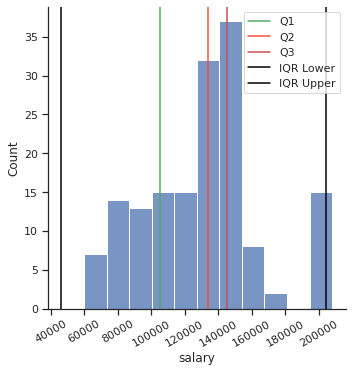

In [113]:
q1 = np.quantile(results_table.salary, 0.25)
q2 = np.quantile(results_table.salary, 0.5)
q3 = np.quantile(results_table.salary, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(results_table.salary)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [114]:
results_table.Q.value_counts()

3    53
4    39
1    38
2    28
Name: Q, dtype: int64

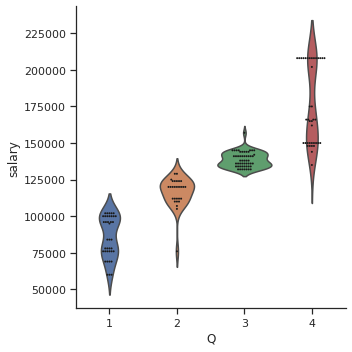

In [117]:
g = sns.catplot(x="Q", y="salary", kind="violin", inner=None, data=results_table)
sns.swarmplot(x="Q", y="salary", color="k", size=2, data=results_table, ax=g.ax)

plt.xticks(rotation=0)

plt.show()

In [116]:
city------------
colmax == 'q3_PROB', probably taken from col name
Company------------
Date Posted----------------
Description
Focus
Job title
JobUrl
Location
Q
Requirements
Role
Schedule
State
Summary
Probability
Q1 = 0 or 1 or null
Q1_posts = 1.0 or 0.0
Q1 pred = binary
Q1 probs

etc

Salary


top terms:
Feature = values == term
Q = class == 'Q1', etc
Imortance == some float

top states:
the same but Feature = states, capitalized

SyntaxError: invalid syntax (<ipython-input-116-a67e56a088d6>, line 1)

In [ ]:

X_tfidf = tfidf.fit_transform(_test).toarray()
vocab = q1_vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)

tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]

df_tfidf['top10']
